### In the following project, I will train a Bidirectional Encoder Representations from Transformers(BERT) using datas collected out of English news on all listed companies in OMX Helsinki. The dataset consists of 4840 sentences from English language financial news categorised by sentiment. The dataset is divided by agreement rate of 5-8 annotators and I will choose the 3453 entries where at least 75% of the annotators agree with the lable.

### And in the second part of the project, similarly, I will build my custom model for text classification based on FinBERT, a pre-trained BERT model that was more specifically for analyzing finance news.

In [1]:
# Install two libraries created by the Huggingface team
!pip install transformers[sentencepiece] datasets

zsh:1: no matches found: transformers[sentencepiece]


### Datasets Library

In [2]:
from datasets import list_datasets
list_datasets()

/var/folders/z3/nr4tym2s3v17r9yd_1z14x_80000gn/T/ipykernel_11623/809330691.py:2: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  list_datasets()


['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews',
 'allocine',
 'alt',
 'amazon_polarity',
 'amazon_reviews_multi',
 'amazon_us_reviews',
 'ambig_qa',
 'americas_nli',
 'ami',
 'amttl',
 'anli',
 'app_reviews',
 'aqua_rat',
 'aquamuse',
 'ar_cov19',
 'ar_res_reviews',
 'ar_sarcasm',
 'arabic_billion_words',
 'arabic_pos_dialect',
 'arabic_speech_corpus',
 'arcd',
 'arsentd_lev',
 'art',
 'arxiv_dataset',
 'ascent_kb',
 'aslg_pc12',
 'asnq',
 'asset',
 'assin',
 'assin2',
 'atomic',
 'autshumato',
 'facebook/babi_qa',
 'banking77',
 'bbaw_egyptian',
 'bbc_hindi_nli',
 'bc2gm_corpus',
 'beans',
 'best2009',
 'bianet',
 'bible_para',
 'big_patent',
 'billsum',
 'bing_coronavirus_query_set',
 'biomrc',
 'biosses',
 'blbooks',
 'blbooksgenre',
 'blended_skill_talk',
 'blimp',
 'blog_authorship_corpus',
 'bn_hate_speech',
 'bnl_newspapers',
 'bookcorpus',
 'bookco

### We load the dataset with 3453 entires where for each entry of labels, at least 75% of the annotators agree with the lable.

#### label 0 = Negative
#### label 1 = Neutral
#### label 2 = Positive

In [3]:
from datasets import load_dataset

fin_news = load_dataset('financial_phrasebank', 'sentences_75agree')
fin_news

Found cached dataset financial_phrasebank (/Users/thomasli/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3453
    })
})

In [4]:
fin_news['train'][0:3]

{'sentence': ['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .',
  "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ."],
 'label': [1, 2, 2]}

### To train the entire dataset would take hours, so to reduce the time, I shrunk the dataset size to 800 entires. And now, to create the test and validation set.

I will take 640 as my training dataset and put 160 towards the validation+test dataset. The validation dataset helps me to see how well the model is training, whether it's overfitting or underfitting.

In [5]:
fin_news['train'] = fin_news['train'].shuffle(seed=1).select(range(800))
fin_news['train']

Loading cached shuffled indices for dataset at /Users/thomasli/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-f7ffdc83e59ee304.arrow


Dataset({
    features: ['sentence', 'label'],
    num_rows: 800
})

In [6]:
fin_news_train_validation = fin_news['train'].train_test_split(train_size=0.8)
fin_news_test_valid = fin_news_train_validation['test'].train_test_split(train_size=0.5)
fin_news_train_validation

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 640
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 160
    })
})

In [7]:
fin_news_test_valid

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 80
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 80
    })
})

In [8]:
fin_news_test_valid['validation'] = fin_news_test_valid.pop('train')
fin_news_test_valid

DatasetDict({
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 80
    })
})

In [9]:
fin_news_train_validation.update(fin_news_test_valid)
fin_news_train_validation

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 640
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 80
    })
})

In [10]:
fin_news.update(fin_news_train_validation)
fin_news

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 640
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 80
    })
})

In [11]:
fin_news['train'][0:3]

{'sentence': ['Conference Call To participate via a conference call , please dial in 5-10 minutes before the beginning of the event : +44 0 20 7162 0025 Europe or +1 334-á323-á6201 USA .',
  "Tekla Structures 16 is ` all about you and your team ' and compatible with the Windows 7 operating system .",
  "The group 's net sales in 2007 were EUR683 .6 m."],
 'label': [1, 1, 1]}

In [12]:
fin_news['test'][0:3]

{'sentence': ['Finnish silicon wafer technology company Okmetic Oyj ( OMX Helsinki : OKM1V ) reported on Thursday ( 7 August ) an operating profit of EUR5 .3 m for the period January-June 2008 , up from EUR3 .3 m in the corresponding period in 2007 .',
  'The implementation of the deal is subject to the approval by the Finnish Competition Authority .',
  'All depends on financing .'],
 'label': [2, 1, 1]}

In [13]:
fin_news['validation'][0:3]

{'sentence': ['The plan is estimated to generate some EUR 5 million ( USD 6.5 m ) in cost savings on an annual basis .',
  'Operating profit in the fourth quarter went down to EUR3m from EUR4 .2 m for the corresponding period of 2009 as it included costs of growth projects .',
  'Earnings per share ( EPS ) amounted to a loss of to EUR0 .06 .'],
 'label': [2, 0, 0]}

### Overview of Financial News Dataset

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 250)

In [15]:
fin_news.set_format('pandas')
df = fin_news['train'][:]
df.sample(frac=1 ,random_state=1).head(10)

,sentence,label
132,"In the third quarter of fiscal 2008 Efore swung to a net loss of EUR 400,000 versus a net profit of EUR 200,000 for the corresponding period of fiscal 2007 .",0
622,The second-quarter net sales are expected to be on par with the first quarter of 2009 .,1
525,With this appointment Kaupthing Bank aims to further co-ordinate Capital Markets activities within the Group and to improve the overall service to clients .,2
289,Finnlines estimated in its annual general meeting that 2008 will be financially a tough year due to large investments .,0
82,"Established in 1987 , the SRV Group is a private Finnish construction concern with operations in Finland , the Baltic countries and Russia .",1
404,Total operating revenue grew by 27.6 % year-on-year to EUR61m .,2
449,Earnings per share EPS in 2005 decreased to EUR0 .66 from EUR1 .15 in 2004 .,0
631,"CapMan Plc Press Release 31 March 2008 Jukka Ruuska , President of the OMX Nordic Exchanges and the Stockholm Stock Exchange , will transfer to CapMan effective no later than September 2008 .",1
626,"The board machine , which will have a wire width of 6.25 m and a design speed of 900 m-min , will produce close to 1,400 tonnes of folding boxboard per day .",1
380,"Suominen Corporation estimates that the cost-cutting program that started in autumn 2005 , higher sales prices , and expected growth in volume of Wet Wipes , will make the company 's operations more profitable .",2


In [16]:
df.loc[0, 'sentence']

'Conference Call To participate via a conference call , please dial in 5-10 minutes before the beginning of the event : +44 0 20 7162 0025 Europe or +1 334-á323-á6201 USA .'

In [17]:
df.label.value_counts()

1    403
2    159
0     78
Name: label, dtype: int64

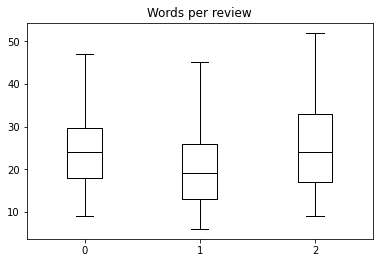

In [18]:
df["Words per review"] = df["sentence"].str.split().apply(len)
df.boxplot("Words per review", by="label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [19]:
#Now that we are done working with the dataset in the pandas format, reset it.
fin_news.reset_format()

## Tokenizer

Now to tokenize each sentences so that we can convert each words to corresponding ids.

In [20]:
from transformers import AutoTokenizer

checkpoint = "bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(batch["sentence"], padding=True, truncation=True)

# The map functions uses apache arrow and make sure that the dataset is stored in the hard disk and only the datas
# we are working with are used so we don't overload our RAM.
fin_news_encoded = fin_news.map(tokenize_function, batched=True, batch_size=None)
fin_news_encoded

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 640
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 80
    })
})

In [21]:
print(fin_news_encoded['train'][0])
print(fin_news_encoded['test'][0])

{'sentence': 'Conference Call To participate via a conference call , please dial in 5-10 minutes before the beginning of the event : +44 0 20 7162 0025 Europe or +1 334-á323-á6201 USA .', 'label': 1, 'input_ids': [101, 3047, 7268, 1706, 4868, 2258, 170, 3511, 1840, 117, 4268, 17693, 1107, 126, 118, 1275, 1904, 1196, 1103, 2150, 1104, 1103, 1856, 131, 116, 3140, 121, 1406, 5729, 1545, 1477, 3135, 17600, 1980, 1137, 116, 122, 3081, 1527, 118, 247, 17101, 1495, 118, 247, 1545, 10973, 1475, 3066, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

There are a lot of zeros above in the input ids because the tokenizer automatically implement a method called padding to ensure every single sample has the same length.

### Tiny Finance Dataset for Transfer Learning

Now that we have our tokenized dataset, we want to pass it through a bert model.

Now, we are adding a classification head on top of the pretrained model with 3 classes/labels. We will then be training the classification head.

In [22]:
import transformers
import re
import torch
from transformers import AutoModelForSequenceClassification

In [23]:
# torch.device for if we can runt it with gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3
model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=num_labels)
         .to(device))

2023-07-04 12:55:53.105366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are 

Now, I want to take a small sample of data, train with that, then see the output. If I'm happy with the output, then I will train the full dataset.

In [24]:
from datasets import DatasetDict

tiny_fin = DatasetDict()
tiny_fin['train'] = fin_news['train'].shuffle(seed=1).select(range(60))
tiny_fin['validation'] = fin_news['validation'].shuffle(seed=1).select(range(10))
tiny_fin['test'] = fin_news['test'].shuffle(seed=1).select(range(10))

tiny_fin_encoded = tiny_fin.map(tokenize_function, batched=True, batch_size=None)
tiny_fin_encoded

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60
    })
    validation: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10
    })
})

In [25]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(tiny_fin_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-tiny-fin-news"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )
training_args

TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_toke

In [26]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=tiny_fin_encoded["train"],
                  eval_dataset=tiny_fin_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss
1,1.170900,1.106294
2,0.946900,1.077049


In [27]:
preds = trainer.predict(tiny_fin_encoded['test'])
preds

PredictionOutput(predictions=array([[-0.29440004,  0.22680606, -0.462095  ],
       [-0.27299467,  0.28101116, -0.36622548],
       [-0.09272022, -0.10450593, -0.5352255 ],
       [-0.47910634,  0.41515416, -0.24438955],
       [-0.23545095,  0.03074569, -0.57453847],
       [-0.40371773,  0.35920107, -0.34404078],
       [-0.3230443 ,  0.34854904, -0.4166343 ],
       [-0.13441944, -0.03062053, -0.5008118 ],
       [-0.15350123,  0.0344452 , -0.4137091 ],
       [-0.61578226,  0.49293873, -0.13759665]], dtype=float32), label_ids=array([1, 1, 0, 1, 2, 1, 1, 2, 2, 1]), metrics={'test_loss': 0.9272069931030273, 'test_runtime': 0.2682, 'test_samples_per_second': 37.288, 'test_steps_per_second': 7.458})

In [28]:
preds.predictions.shape

(10, 3)

In [29]:
preds.predictions.argmax(axis=-1)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [30]:
preds.label_ids

array([1, 1, 0, 1, 2, 1, 1, 2, 2, 1])

In [31]:
from sklearn.metrics import accuracy_score

accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))

0.7

In [32]:
def get_accuracy(preds):
  predictions = preds.predictions.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))
  return {'accuracy': accuracy}


In [33]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model, 
                  compute_metrics=get_accuracy,
                  args=training_args, 
                  train_dataset=tiny_fin_encoded["train"],
                  eval_dataset=tiny_fin_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,0.794100,0.993997,0.500000
2,0.724500,0.956667,0.500000


### We see that the predictions versus the actual labels for each sentence are mostly accurate, and we also received a high accuracy score, so we are ready to proceed with the full training run.

## Training Run

In [34]:
batch_size = 14
logging_steps = len(fin_news_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-fin-news"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

In [35]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=get_accuracy,
                  train_dataset=fin_news_encoded["train"],
                  eval_dataset=fin_news_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,0.670200,0.611961,0.725000
2,0.395700,0.396746,0.850000
3,0.228300,0.317924,0.887500
4,0.135900,0.307630,0.925000


In [36]:
trainer.evaluate()

{'eval_loss': 0.3076297640800476,
 'eval_accuracy': 0.925,
 'eval_runtime': 5.2913,
 'eval_samples_per_second': 15.119,
 'eval_steps_per_second': 1.134,
 'epoch': 4.0}

In [37]:
trainer.save_model()
model_name

'bert-base-cased-finetuned-fin-news'

In [38]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis', model=model_name)
classifier('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .')

[{'label': 'LABEL_0', 'score': 0.7051867246627808}]

In [39]:
classifier('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .')

[{'label': 'LABEL_1', 'score': 0.9416850805282593}]

In [40]:
classifier('For the last quarter of 2010 , Componentas net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .')

[{'label': 'LABEL_2', 'score': 0.9790472388267517}]

The scores above mean that the model is score*100 percent sure that the last sentence has a positive sentiment.

### Now we see that the model can successfully identify each of these sentences as negative, neutral, and positive. We have successfully trained a BERT model on the financial news dataset.

### Up next, I will perform a fine-tuning on the FinBert model, a pre-trained NLP model that's more specifically for analyzing the sentiment of financial text.

In [41]:
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import transformers
torch.__version__, transformers.__version__

('2.0.1', '4.30.2')

#### Reload the dataset.

In [42]:
fin_news = load_dataset('financial_phrasebank', 'sentences_75agree')
fin_news.set_format('pandas')
df = fin_news['train'][:]
df

Found cached dataset financial_phrasebank (/Users/thomasli/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

,sentence,label
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",1
1,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,2
2,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",2
3,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",2
4,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,2
...,...,...
3448,"Operating result for the 12-month period decreased from the profit of EUR0 .4 m while turnover decreased from EUR5 .6 m , as compared to 2004 .",0
3449,"HELSINKI Thomson Financial - Shares in Cargotec fell sharply in early afternoon trade after the cargo handling group posted a surprise drop in April-June profits , which overshadowed the large number of new orders received during the three months .",0
3450,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,0
3451,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .",0


#### Prepare Training/Testing/Validation

In [43]:
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(2796, 2) (346, 2) (311, 2)


### Load FinBERT pretrained model

The pretrained FinBERT model path on Huggingface is https://huggingface.co/yiyanghkust/finbert-pretrain

In [44]:
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

### Prepare dataset for fine tuning

In [45]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/2796 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

### Define Training Options

In [46]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=model,                        
        args=args,                  
        train_dataset=dataset_train,         
        eval_dataset=dataset_val,           
        compute_metrics=compute_metrics
)

trainer.train()   

/Users/thomasli/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.2133120745420456, 'eval_accuracy': 0.9389067524115756, 'eval_runtime': 49.0747, 'eval_samples_per_second': 6.337, 'eval_steps_per_second': 0.204, 'epoch': 1.0}
{'eval_loss': 0.13591976463794708, 'eval_accuracy': 0.954983922829582, 'eval_runtime': 30.1679, 'eval_samples_per_second': 10.309, 'eval_steps_per_second': 0.331, 'epoch': 2.0}
{'eval_loss': 0.11966689676046371, 'eval_accuracy': 0.9581993569131833, 'eval_runtime': 64.92, 'eval_samples_per_second': 4.791, 'eval_steps_per_second': 0.154, 'epoch': 3.0}
{'train_runtime': 3528.7009, 'train_samples_per_second': 2.377, 'train_steps_per_second': 0.075, 'train_loss': 0.26787281036376953, 'epoch': 3.0}


TrainOutput(global_step=264, training_loss=0.26787281036376953, metrics={'train_runtime': 3528.7009, 'train_samples_per_second': 2.377, 'train_steps_per_second': 0.075, 'train_loss': 0.26787281036376953, 'epoch': 3.0})

### Evaluate on Training Set

In [47]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.1803191900253296,
 'test_accuracy': 0.9393063583815029,
 'test_runtime': 34.43,
 'test_samples_per_second': 10.049,
 'test_steps_per_second': 0.319}

### Save the fine-tuned model

In [48]:
trainer.save_model('finbert-sentiment-fine-tuned')